### purpose

show distribution of k that was used for input to lfmm genetic.offset function - these values were determined in Lotterhos 2023

In [1]:
from pythonimports import *
from myfigs import histo_box

import MVP_summary_functions as mvp
import MVP_10_train_lfmm2_offset as mvp10

import seaborn as sns
plt.rcParams.update({'font.family' : 'serif'})

lview, dview = get_client(cluster_id='1693229824-77av', profile='lotterhos')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	August 28, 2023 - 09:37:19 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 9493334506a1f2926fba0734fa74ba2f87194611  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 30 09:41:00 2023 -0400

Current commit of MVP_offsets:
commit 59196546230c84b45ac4d8cd5c35052fdf910eb8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Aug 28 09:12:58 2023 -0400
#########################################################



In [2]:
# get the lfmm files to pull K from
lfmm_files = fs(mvp.slimdir, pattern='lfmm', endswith='temp.RDS')

len(lfmm_files)  # 225 levels * 10 replicates

2250

In [3]:
# write a script to pull K from an lfmm file
script_exe = '/home/b.lind/code/MVP-offsets/01_src/lfmm_k_reader.R'

text = '''
library(LEA)
print(sessionInfo())

args = commandArgs(trailingOnly=TRUE)

rds_file = args[1]

K <- readRDS(rds_file)@K

print(sprintf('K = %s', K))

'''

with open(script_exe, 'w') as o:
    o.write(text)

In [4]:
# write a python function to use the r script
def read_K(rds):
    import sys
    import subprocess

    output = subprocess.check_output(
        [
            '/home/b.lind/anaconda3/envs/MVP_env_R4.0.3/bin/Rscript',
            script_exe,
            rds
        ]
    ).decode('utf-8')
    
    return output
    
dview['script_exe'] = script_exe

In [5]:
# test out function
print(
    read_K(
        lfmm_files[0]
    )
)

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /work/lotterhos/brandon/anaconda3/envs/MVP_env_R4.0.3/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] LEA_3.8.0

loaded via a namespace (and not attached):
[1] compiler_4.0.3
[1] "K = 2"



In [6]:
# run function in parallel
jobs = []
for f in lfmm_files:
    jobs.append(
        lview.apply_async(
            read_K, f
        )
    )

watch_async(jobs)


Watching 2250 jobs ...


100%|███████████████| 2250/2250 [01:24<00:00, 26.54it/s]


100%|███████████████| 2250/2250 [00:00<00:00, 110614.47it/s]


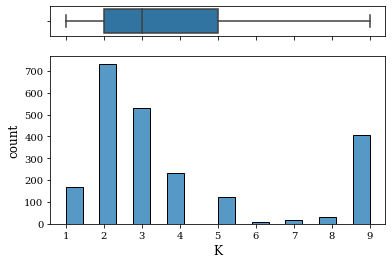

In [7]:
# retrieve values, make a figure
vals = {}
for i, j in enumerate(pbar(jobs)):
    seed = op.basename(lfmm_files[i]).split("_")[0]
    
    vals[seed] = int(
        j.r.split('\n')[-2].split()[-1][0]
    )
    
_ = histo_box(vals.values(), xlab='K', ylab='count')

### now split according to levels

In [8]:
params = mvp10.read_params_file('/home/b.lind/offsets/run_20220919_0-225/slimdir')

params.head()

,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231094
1231095,highly-polygenic_1-trait__Est-Clines_N-cline-N...,1,highly-polygenic_1-trait,Est-Clines_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,2,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231095
1231096,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m_breaks,N-equal_m_breaks,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,1,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231096
1231097,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m-constant,N-equal_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231097
1231098,highly-polygenic_1-trait__Est-Clines_N-variabl...,1,highly-polygenic_1-trait,Est-Clines_N-variable_m-variable,N-variable_m-variable,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,3,1,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231098


In [9]:
params.demog_name.str.split("_")#.apply(lambda x: x[0])

1231094    [Est-Clines, N-cline-center-to-edge, m-constant]
1231095            [Est-Clines, N-cline-N-to-S, m-constant]
1231096                    [Est-Clines, N-equal, m, breaks]
1231097                   [Est-Clines, N-equal, m-constant]
1231098                [Est-Clines, N-variable, m-variable]
                                 ...                       
1233339        [SS-Mtn, N-cline-center-to-edge, m-constant]
1233340                [SS-Mtn, N-cline-N-to-S, m-constant]
1233341                        [SS-Mtn, N-equal, m, breaks]
1233342                       [SS-Mtn, N-equal, m-constant]
1233343                    [SS-Mtn, N-variable, m-variable]
Name: demog_name, Length: 2250, dtype: object

In [10]:
k_data = pd.DataFrame(vals, index=['K']).T

k_data['landscape'] = k_data.index.map(params.demog_name.str.split("_").apply(lambda x: x[0]))

k_data.head()

,K,landscape
1231094,2,Est-Clines
1231095,9,Est-Clines
1231096,9,Est-Clines
1231097,9,Est-Clines
1231098,6,Est-Clines


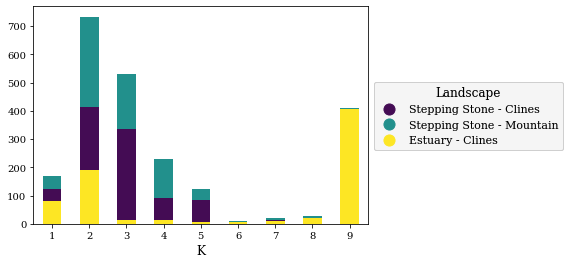

In [11]:
df = pd.DataFrame(
    k_data.groupby('K')['landscape'].apply(Counter)
).reset_index().pivot(
    index='K', columns='level_1'
)

df.columns = df.columns.get_level_values('level_1').tolist()

ax = df.plot(kind='bar',
             stacked=True,
             color=df.columns.map(mvp.boxplot_kwargs['palette']).tolist()) #pd.Series(mvp.hue_order['landscape']).map(mvp.boxplot_kwargs['palette']).tolist())
ax.legend_.remove()

ax.set_xlabel('K', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360)

mvp.add_legend(ax.figure, color_by='landscape', loc='center left', bbox_to_anchor=(0.9, 0.5))

In [12]:
boxplot_kws = defaultdict(dict)

boxplot_kws['flierprops'].update({
            'markersize' : 8,
            'zorder' : 0,
            'markerfacecolor': 'gray',
            'alpha': 0.5,
            'markeredgewidth' : 0.0,
    # remove edge if markeredgewidth==0

})  

<AxesSubplot:xlabel='K'>

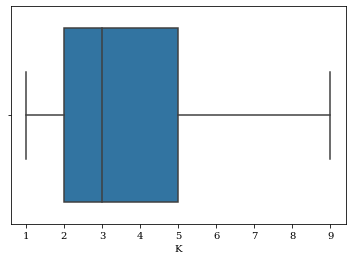

In [13]:
sns.boxplot(x=k_data['K'])

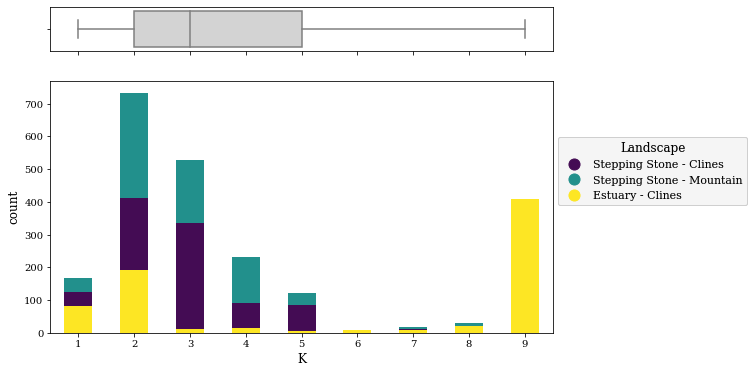

In [14]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(9, 6), gridspec_kw={"height_ratios": (.15, .85)})


df = pd.DataFrame(k_data.groupby('K')['landscape'].apply(Counter)).reset_index().pivot(
    index='K', columns='level_1'
)
df.columns = df.columns.get_level_values('level_1').tolist()


sns.boxplot(
    x=k_data['K'] - 1,  # need to subtract 1 because seaborn starts at position 0, matplotlib starts at position 1
    ax=ax_box,
    color='lightgray',
    **boxplot_kws
)


ax = df.plot(kind='bar',
             stacked=True,
             color=df.columns.map(mvp.boxplot_kwargs['palette']).tolist(),
             ax=ax_hist
            )

ax.legend_.remove()
mvp.add_legend(ax.figure, color_by='landscape', loc='center left', bbox_to_anchor=(0.9, 0.5))

ax_hist.set_xlabel('K', fontsize=12)
ax_hist.set_ylabel('count', fontsize=12)
_ = ax_hist.set_xticklabels(ax.get_xticklabels(), rotation=360)



In [15]:
k_data

,K,landscape
1231094,2,Est-Clines
1231095,9,Est-Clines
1231096,9,Est-Clines
1231097,9,Est-Clines
1231098,6,Est-Clines
...,...,...
1233339,3,SS-Mtn
1233340,3,SS-Mtn
1233341,1,SS-Mtn
1233342,2,SS-Mtn


In [16]:
k_data.to_csv('/home/b.lind/offsets/k_data_from_lfmm.txt', index=True, header=True, sep='\t')

In [17]:
k_data

,K,landscape
1231094,2,Est-Clines
1231095,9,Est-Clines
1231096,9,Est-Clines
1231097,9,Est-Clines
1231098,6,Est-Clines
...,...,...
1233339,3,SS-Mtn
1233340,3,SS-Mtn
1233341,1,SS-Mtn
1233342,2,SS-Mtn
